In [2]:
import fb
import requests

# generate a token: https://developers.facebook.com/tools/explorer/

# this one is mine and no longer valid by the time you run this, of course ;)
access_token='CAACEdEose0cBAGpPaG5vF0muEi27Jt0ZAOSYshiFyXdK7NwsZCbeaaTSZCY2RyXmgTeogVjiy5f6ZBmXuiZCZAwcZBqxZBew1e8a4xZAgyaiwAAPR7B7ciZCJKb8zQ5dXQAbYnoRsZCdxMC9OiXokx5x41tXuMMK80SV5OroEm2k6XmeyaNTeJAZBWC7YAKhPakXSfIeb9kADx1aTfYZBF0WG2qYu'

# find your user id here, based on your username: http://findmyfbid.com/
user_id='513144150'

In [3]:
## May take a while depending on how many posts there are.
face=fb.graph.api(access_token)
all_posts = []
posts = face.get_object(cat='single', id='me', fields=['posts'], limit=100)

posts = posts['posts']
datum = posts['data'][0]['created_time']
while datum.startswith('20'): #TODO: remove this
    for idx, posts_data in enumerate(posts['data']):
        datum = posts_data['created_time']
        if 'message' in posts_data and datum.startswith('20') : #TODO: remove this
            all_posts.append(posts_data['message'])
            # print "created... %s " % posts_data['created_time']
    posts = requests.get(posts['paging']['next']).json()

In [4]:
# get all photo descriptions

face=fb.graph.api(access_token)
all_photos = []
photos = face.get_object(cat='single', id="me", fields=['albums{photos}'], limit=100)

In [5]:
def get_photo_label(album_photos):
    for album_photo in album_photos['data']:
        if 'name' in album_photo.keys():
            #print "photo name: %s" % album_photo['name']
            photo_name = album_photo['name']
            if photo_name not in all_photos:
                all_photos.append(album_photo['name'])
    if 'next' in album_photos['paging'].keys():
        #print "next: %s" % album_photos['paging']['next']
        more_photos = requests.get(album_photos['paging']['next']).json()
        get_photo_label(more_photos)

In [6]:
albums = photos['albums']['data']
datum = albums[0]['created_time']
for album in albums:
    if 'photos' in album.keys():
        #print "number of photos: %s " % len(album['photos']['data'])
        get_photo_label(album['photos'])

In [12]:
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords

In [13]:
def review_to_words(raw_review):
    # Remove non-letters       
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # convert to lower case, split into words
    words = letters_only.lower().split()
    # searching a set is much faster than searching a list, so convert to set first
    stops_english = set(stopwords.words("english"))
    stops_dutch = set(stopwords.words("dutch"))
    # remove stopwords
    meaningful_words = [w.lower() for w in words if not w in stops_english and not w in stops_dutch and len(w)>3]
    # 6. join the words into one string separated by space
    return(" ".join(meaningful_words))

In [14]:
clean_posts = []

for post in all_posts+all_photos:
    clean_posts.append(review_to_words(post))

In [15]:
import gensim
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [16]:
def docList(docs):
    for doc in docs:
        tokens = tokenizer.tokenize(doc)
        tokens = [ t for t in tokens ]
        yield tokens

In [17]:
dic = gensim.corpora.Dictionary.from_documents(docList(clean_posts))

In [18]:
# dic.items()
dic.save('facebook_posts_vocab.gensim.dic')

In [19]:
corpus = [dic.doc2bow(post) for post in docList(clean_posts)]

In [20]:
from scipy.sparse import csr_matrix
data = []
row  = []
col  = []
for n,doc in enumerate(corpus):
    for w,c in doc:
        col.append(n)
        row.append(w)
        data.append(c)

nSamples = len(corpus)
nFeatures = len(dic)
mm = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))

In [21]:
print "nSamples (posts) : ",nSamples
print "nFeatures(words): ",nFeatures
len(corpus),len(dic)

nSamples (posts) :  2927
nFeatures(words):  3449


(2927, 3449)

In [74]:
nTopics = 8
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=nTopics, max_iter=40,
                                learning_method='online', learning_offset=50.
                                #,random_state=0
                               )
lda.fit(mm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=40, mean_change_tol=0.001,
             n_jobs=1, n_topics=8, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [75]:
def getDocumentTopics(docTokens, lda):
    wcTuples = dic.doc2bow(docTokens)
    data = []
    row  = []
    col  = []

    for w,c in wcTuples:
        col.append(0)
        row.append(w)
        data.append(c)

    nSamples = 1
    nFeatures = len(dic)
    oneDoc = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))
    docWeights = lda.transform(oneDoc)[0]
    docWeights /= docWeights.sum()
    return docWeights

topicWords = []
topicWeightedWords = []

for topic_idx, topic in enumerate(lda.components_):
    weightedWordIdx = topic.argsort()[::-1]
    wordsInTopic = [dic[i] for i in weightedWordIdx[:10]]

    weights = topic / topic.sum()
    topicWeights = [ (weights[i],dic[i]) for i in weightedWordIdx[:10]]
    
    print "Topic #%d:" % topic_idx
    print " ".join(wordsInTopic)
    topicWords.append(wordsInTopic)
    topicWeightedWords.append(topicWeights)

Topic #0:
true world beach amazing skopje another nikola rooftop idea courtesy
Topic #1:
google http christmas nice book dutch would place schiphol photos
Topic #2:
tropez paprika stuffed making play happy eating know around hate
Topic #3:
time need take summer long best progress talk please heart
Topic #4:
amsterdam good love night well science know getting ready going
Topic #5:
right today thanks first ever always many guess finally things
Topic #6:
life cern made damn must still real thank years people
Topic #7:
like almost moment kiril miss someone brussels voila chocolate berlin


In [76]:
# nTopics = 10
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

img = []
for idx,topic in enumerate(topicWeightedWords):
    wc = WordCloud(background_color="white")
    img.append(wc.generate_from_frequencies([ (word, weight) for weight,word in topic ]))
#     subplot(nTopics,2,2*idx+1)
#     imshow(img)
#     axis('off')
#     imshow(img)

Populating the interactive namespace from numpy and matplotlib


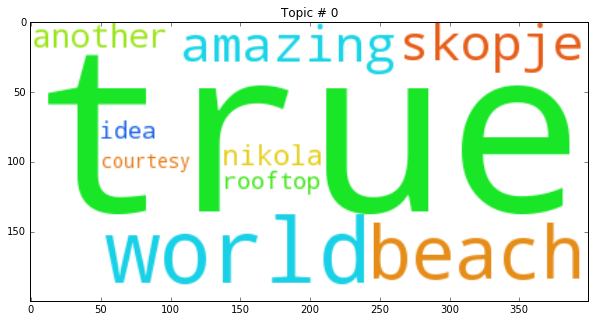

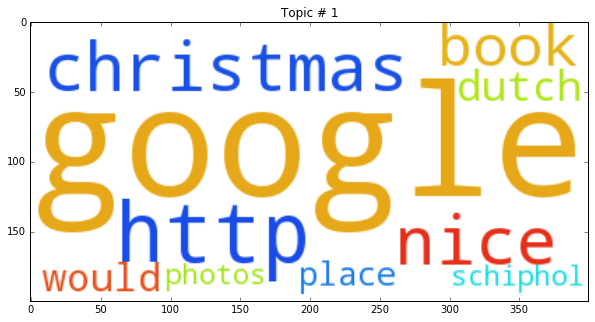

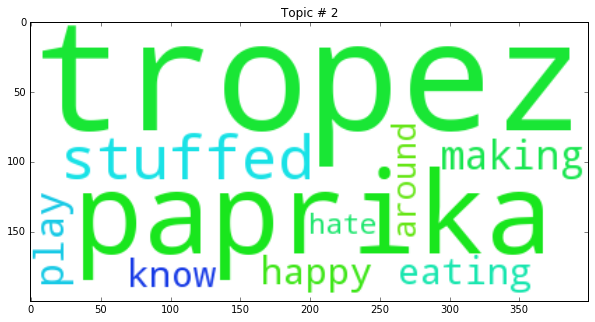

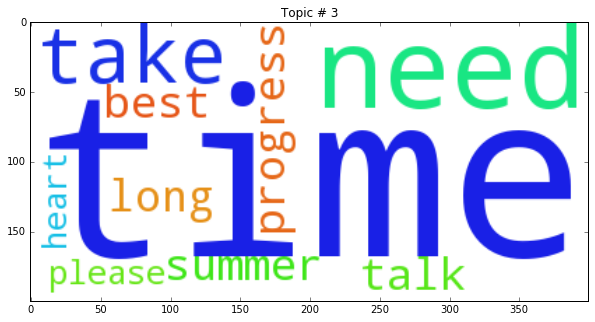

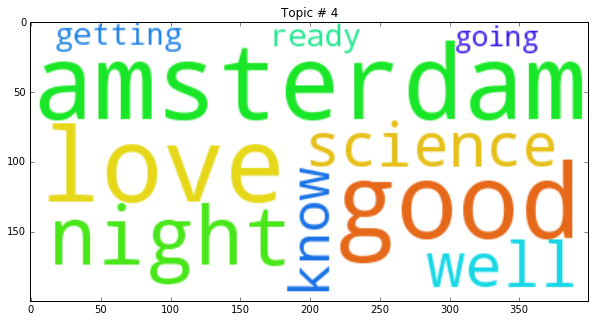

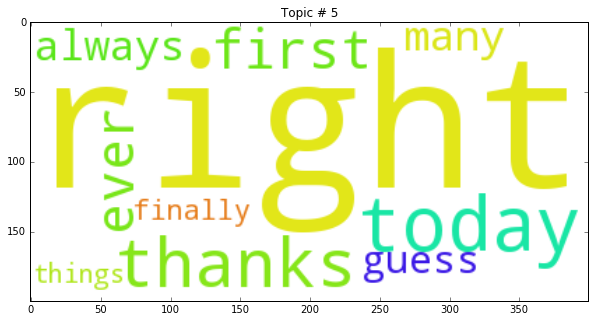

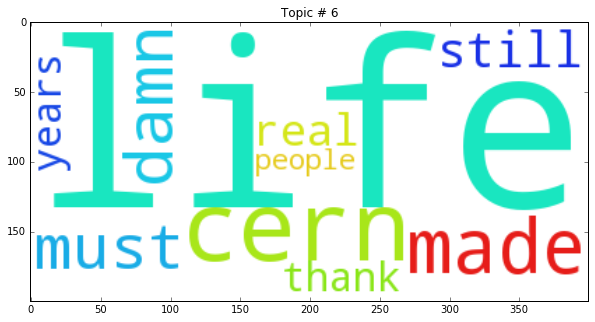

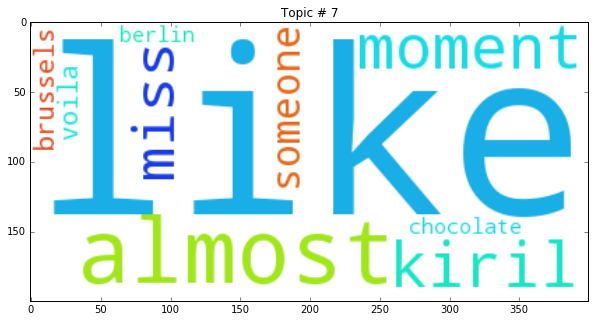

In [77]:
for idx, im in enumerate(img):
    figure(figsize=(10,5))
    title('Topic #%2d'%(idx))
    imshow(im)